# Train YOLOv2 on LISA Dataset
---------------------------------------------
This notebook will cover:
* How to prepare dataset (Lisa), including loading data and pre-processing
* How to construct YOLO-v2 and load pretrained weights
* How to train model on GPU or multi-gpus



In [1]:
import sys
print(sys.version) # Check Python Version

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### Prepare LISA Dataset

In [2]:
lisa_path = "/home/dat/Downloads/training/" # Remember the `/` at the end

In [3]:
import numpy as np
from utils.load_data import load_data    # Data handler for LISA dataset

x_train, y_train = load_data(lisa_path)
labels           = np.unique(y_train['Annotation tag'])
num_classes      = len(labels)  # Count number of classes in the dataset

print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))

Train: 3672 samples
Number of classes: 31


In [4]:
# Save to txt file
# import pandas as pd
# df = pd.concat([x_train, y_train], axis = 1)
# np.savetxt("training.txt", df.values, delimiter=',', fmt='%s')

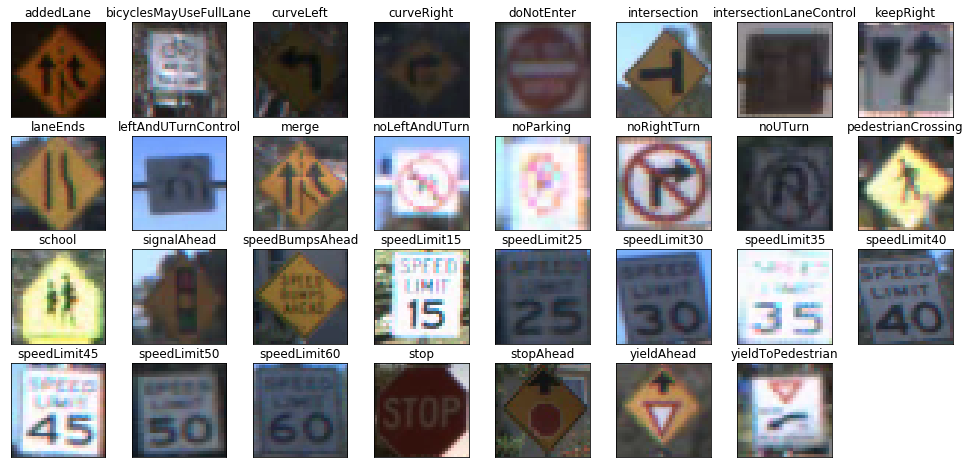

In [5]:
import cv2
import pandas as pd
import numpy as np
from utils.img_handler import extract_sign
import matplotlib.pyplot as plt
%matplotlib inline

tmp = pd.concat([x_train, y_train], axis=1)
shuffled = tmp.sample(frac=1)
x_train = shuffled.iloc[:, 0]
y_train = shuffled.iloc[:, 1:]

fig = plt.figure(figsize=(17, 8))
for i, label in enumerate(labels):
    ax           = fig.add_subplot(4, 8, 1 + i, xticks=[], yticks=[])
    idx          = y_train.loc[y_train['Annotation tag'] ==  label].index[0]
    img          = cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB)
    label_idx    = y_train.loc[idx]
    sign_only    = extract_sign(img, label_idx) #  just extract the sign
    ax.set_title(label)
    plt.imshow(sign_only)
plt.show()

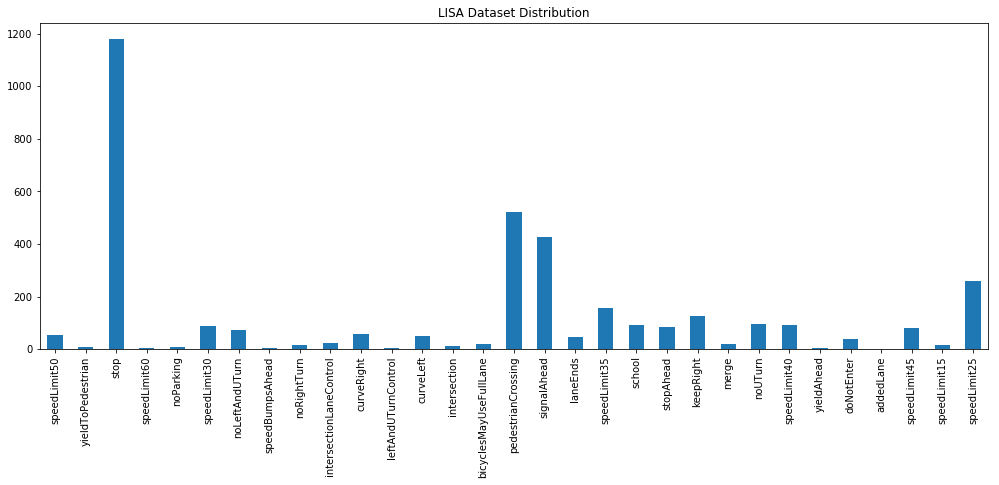

In [6]:
# Traffic Sign Frequencies 
freq = y_train['Annotation tag'].value_counts(sort=False)
# Create a histogram bar chart for visualization
freq.plot(kind='bar',figsize =(17, 6), fontsize=10,
          title='LISA Dataset Distribution')

### Construct YOLOv2 On Keras

#### How to convert DarkNet Model Weights to Keras Weights
   * Download DarkNet Weights: [here]() (I used DarkNet 19 544x544)
   * Clone this repo: YAD2K
   * Run this script to convert DarkNet to Keras Model
   * Run `extract_weights.py` to extract Keras Weights

In [7]:
pretrained_path = "/home/ubuntu/dataset/darknet19_544.weights"

In [8]:
from DarkNet import Yolo2

darknet = Yolo2(img_size=(None, None, 3), weight_path=pretrained_path, num_classes=31, num_anchors=5)
model   = darknet.get_model()

print(model.summary())

Using TensorFlow backend.


TypeError: __init__() got an unexpected keyword argument 'img_size'

### YOLOv2 LOSS
---------
https://github.com/pjreddie/darknet/blob/master/src/region_layer.c#L174

In [ ]:
import keras.backend as K
import tensorflow as tf

def yolo_loss(anchors, num_classes):
    """
    Loss Function for YOLO v2
    :return: loss value - float
    """
    # Described here : https://github.com/fchollet/keras/issues/2121
    def total_loss(y_true, y_pred):
        yolo_output = y_pred
        
        # Extract ground truth from value
        true_boxes, detectors_mask, matching_true_boxes  = extract_label(y_true, anchors, num_classes)
        
        # Extract prediction from last conv layer
        pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(yolo_output, anchors, num_classes)
        num_anchors       = len(anchors)
        object_scale      = 5
        no_object_scale   = 1
        class_scale       = 1
        coordinates_scale = 1
                                                                    
        
        # Unadjusted box predictions for loss.
        # TODO: Remove extra computation shared with yolo_head.
        yolo_output_shape = K.shape(yolo_output)
        feats = K.reshape(yolo_output, [-1, yolo_output_shape[1], yolo_output_shape[2], num_anchors, num_classes + 5])

        pred_boxes = K.concatenate((K.sigmoid(feats[..., 0:2]),  # Center point
                                    feats[..., 2:4]),            # [w, h]
                                    axis=-1)

        # TODO: Adjust predictions by image width/height for non-square images?
        pred_xy = K.expand_dims(pred_xy, 4)
        pred_wh = K.expand_dims(pred_wh, 4)

        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half

        true_boxes_shape = K.shape(true_boxes)
        # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
        true_boxes = K.reshape(true_boxes, [true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]])
        true_xy = true_boxes[..., 0:2]  # Center point
        true_wh = true_boxes[..., 2:4]

        # Find IOU of each predicted box with each ground truth box.
        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half  # [x1. y1]
        true_maxes   = true_xy + true_wh_half  # [x2  y2]

        # Find intersection area
        intersect_mins  = K.maximum(pred_mins, true_mins)
        intersect_maxes = K.minimum(pred_maxes, true_maxes)
        intersect_wh    = K.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]  # Area = Width * Height
        true_areas = true_wh[..., 0] * true_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores = intersect_areas / union_areas

        # Best IOUs for each location.
        best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
        best_ious = K.expand_dims(best_ious)

        # A detector has found an object if IOU > thresh for some true box.
        object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious))

        # TODO: Darknet region training includes extra coordinate loss for early
        # Determine confidence weights from object and no_object weights.
        no_object_weights = no_object_scale * (1 - object_detections) * (1 - detectors_mask)
        no_objects_loss   = no_object_weights * K.square(-pred_confidence)
        objects_loss = (object_scale * detectors_mask * K.square(1 - pred_confidence))

        # Objectiveness Loss
        confidence_loss = objects_loss + no_objects_loss

        # Classification loss for matching detections.
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
        matching_classes = K.one_hot(matching_classes, num_classes)
        classification_loss = class_scale * detectors_mask * K.square(matching_classes - pred_class_prob)

        # Coordinate loss for matching detection boxes.
        matching_boxes   = matching_true_boxes[..., 0:4]
        coordinates_loss = (coordinates_scale * detectors_mask * K.square(matching_boxes - pred_boxes))

        # Total loss
        confidence_loss_sum     = K.sum(confidence_loss)
        classification_loss_sum = K.sum(classification_loss)
        coordinates_loss_sum    = K.sum(coordinates_loss)
        total_loss              = 0.5 * (confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)

        return total_loss
    return total_loss


def yolo_head(net_output, anchors, num_classes):
    """
    Convert Map Features output from network to bounding box
    
    Parameters
    -----------
    :param net_output: Final Convolutional layer 
    :param anchors:    array-like - Anchor box widths and heights [defined in K-clustering]
    :param num_classes: number of target classes
     
    :return: 
            box_xy : tensor
                    x, y box predictions adjusted by spatial location in conv layer
            box_wh : tensor
                    w, h box predictions adjusted by anchors and conv spatial resolution          
            box_conf : tensor
                    Probability estimate to whether each box contains any object
            box_class_pred: tensor
                    Probability distribution estimate for each box over class labels
                    
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(net_output)[1:3]  # assuming channels last
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(net_output))

    feats = K.reshape(net_output, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy          = K.sigmoid(feats[..., :2])
    box_wh          = K.exp(feats[..., 2:4])
    box_confidence  = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust predictions to each spatial grid point and anchor size.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

def extract_label(y_true, anchors, num_classes):
    """
    Return
        [trueboxes, detector_mask, matching_ground_truth]
    """
    num_anchors = len(anchors)
    
    # Get bbox
    gt_boxes = K.arrange(0, stop=)

In [ ]:
# HYPER-PARAMETERS
BATCH_SIZE = 64
EPOCHS     = 5
LEARN_RATE = 0.01

In [ ]:
import keras
import pandas as pd
from utils.data_generator import flow_from_list

anchors  = np.array(((0.57273, 0.677385),
                     (1.87446, 2.06253),
                     (3.33843, 5.47434),
                     (7.88282, 3.52778),
                     (9.77052, 9.16828)))
train_data_gen = flow_from_list(x_train, y_train, anchors, batch_size=BATCH_SIZE)

In [ ]:
# Compile and train model
import os
from keras.optimizers import Adam


detectors_mask       = np.array([])
matching_true_boxes  =  np.array([])

model.compile(optimizer= Adam(LEARN_RATE),
              loss     = yolo_loss(anchors, num_classes),  
              metrics  = ['acc'])

In [ ]:
hist =  model.fit_generator(generator       = train_data_gen, 
                            steps_per_epoch = len(x_train) / BATCH_SIZE, 
                            epochs          = 10, 
                            workers=1, 
                            pickle_safe=False, 
                            verbose=1, 
                            initial_epoch   = 0,
                            callbacks=[tf_board, check_pt])
model.save_weights('darknet_weights.h5')

## Multi-GPUs Training - Data Parallelism Approach

* Each GPU will have a copy of the model
* During training time, mean of all gradidents from each GPU will be calculated to update the model
<img style="width:40%" src="https://www.tensorflow.org/images/Parallelism.png">

### Visualize training process using Tensorboard
Open `http://<public-dns>:6006`